In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

import sys
sys.path.append("../scripts")
from TrackReconstruction_functions import *

import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph, GATConv, global_mean_pool, TransformerConv
from torch_geometric.utils import to_networkx

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import networkx as nx

%matplotlib widget

In [2]:
# Check for CUDA (NVIDIA) or MPS (Apple)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

NVIDIA GeForce RTX 2060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Using device: cuda


In [3]:
# Load in the signal metadata
nubb_meta = pd.read_hdf(f"/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_0nubb/1bar/5percent/reco_filtered/ATPC_0nubb_1bar_5percent_filtered.h5", "MC/hits")
nubb_meta["Type"] = "0nubb"
nubb_meta["subType"] = "0nubb"
display(nubb_meta)

# ----------------------------------------------------------------------------------------------------

# Load in the background
Bkg_meta = pd.DataFrame()
Tl_meta = pd.DataFrame()
Bi_meta = pd.DataFrame()

Tl_meta = pd.read_hdf(f"/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_Tl_ion/1bar/5percent/reco_filtered/ATPC_Tl_ion_1bar_5percent_filtered.h5", "MC/hits")
Tl_meta["subType"] = "Tl"
Bi_meta = pd.read_hdf(f"/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_Bi_ion/1bar/5percent/reco_filtered/ATPC_Bi_ion_1bar_5percent_filtered.h5", "MC/hits")
Bi_meta["subType"] = "Bi"
single_meta = pd.read_hdf(f"/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_single/1bar/5percent/reco_filtered/ATPC_single_1bar_5percent_filtered.h5", "MC/hits")
single_meta["subType"] = "single"

Bkg_meta = pd.concat([Tl_meta, Bi_meta, single_meta])

Bkg_meta["Type"] = "Bkg"


display(Bkg_meta)

df = pd.concat([nubb_meta, Bkg_meta])
df = df.drop(columns=['x_smear', 'y_smear', 'z_smear'])


# ----------------------------------------------------------------------------------------------------

# Load in the pickle files

def LoadPickle(f):
    # Load Bi data
    with open(f, 'rb') as pickle_file:
        Tracks = pickle.load(pickle_file)
        connections = pickle.load(pickle_file)
        connection_counts = pickle.load(pickle_file)
        
        return Tracks, connections, connection_counts

Tracks_0nubb,  connections_0nubb, connection_counts_0nubb   = LoadPickle("/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_0nubb/1bar/5percent/reco_filtered/ATPC_0nubb_1bar_5percent_pkl_filtered.h5")
Tracks_Bi,     connections_Bi, connection_counts_Bi         = LoadPickle("/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_Bi_ion/1bar/5percent/reco_filtered/ATPC_Bi_ion_1bar_5percent_pkl_filtered.h5")
Tracks_Tl,     connections_Tl, connection_counts_Tl         = LoadPickle("/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_Tl_ion/1bar/5percent/reco_filtered/ATPC_Tl_ion_1bar_5percent_pkl_filtered.h5")
Tracks_Single, connections_Single, connection_counts_Single = LoadPickle("/media/argon/HardDrive_8TB/Krishan/ATPC/trackreco/ATPC_single/1bar/5percent/reco_filtered/ATPC_single_1bar_5percent_pkl_filtered.h5")

# Merge dictionaries
Tracks = {**Tracks_0nubb, **Tracks_Bi, **Tracks_Tl, **Tracks_Single}
connections = {**connections_0nubb,**connections_Bi, **connections_Tl,**connections_Single}
connection_counts = {**connection_counts_0nubb, **connection_counts_Bi, **connection_counts_Tl, **connection_counts_Single}


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity,Type,subType
0,122,-1561.886724,-1493.918611,1512.290522,-1554.677368,-1489.785767,1508.124512,0.034792,0,0,1,0,0.000000,0.000000,2.125385,1.089913,0nubb,0nubb
1,122,-1544.894696,-1493.918611,1512.290522,-1543.320435,-1489.691711,1512.508423,0.094080,0,1,1,0,12.174049,138.048060,2.125385,1.089913,0nubb,0nubb
2,122,-1544.894696,-1476.926583,1512.290522,-1538.769165,-1480.243164,1513.530762,0.042178,0,2,1,0,22.711329,63.589735,2.046881,1.173988,0nubb,0nubb
3,122,-1527.902668,-1476.926583,1512.290522,-1531.169312,-1484.254028,1508.881348,0.003365,0,5,1,0,32.481788,94.490763,2.000895,1.322042,0nubb,0nubb
4,122,-1527.902668,-1493.918611,1512.290522,-1531.922852,-1491.922974,1513.565308,0.003935,0,4,1,0,41.499549,87.883052,2.065185,1.533477,0nubb,0nubb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,189786,2242.141629,-1737.116247,5360.944639,2248.882812,-1739.777954,5353.361328,0.065982,0,89,1,0,3140.165926,71.406394,3.658627,3.057292,0nubb,0nubb
102,189786,2269.775364,-1737.116247,5360.944639,2269.233398,-1727.197876,5367.596680,0.004590,0,95,1,0,3168.005645,54.132231,2.292515,1.749446,0nubb,0nubb
103,189786,2297.409099,-1709.482512,5333.310904,2288.433350,-1722.446777,5338.488281,0.025594,0,102,1,0,3203.198114,87.886567,1.692427,0.991755,0nubb,0nubb
104,189786,2297.409099,-1709.482512,5305.677169,2299.638550,-1718.641418,5300.070557,0.041808,0,104,1,0,3243.397105,17.191315,1.383993,0.598166,0nubb,0nubb


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity,subType,Type
0,690067,1003.089627,-2084.759265,3774.037535,1005.368469,-2091.740967,3764.789551,0.027345,1,76,1,0,0.000000,0.000000,1.614405,0.986878,Tl,Bkg
1,690067,1003.089627,-2084.759265,3751.164581,1004.472310,-2087.679606,3757.281576,0.135265,1,73,1,0,8.582974,141.720230,1.708385,1.136662,Tl,Bkg
2,690067,1003.089627,-2061.886311,3774.037535,1003.787231,-2069.358643,3764.071533,0.011411,1,72,1,0,28.133692,81.762210,1.580232,1.042142,Tl,Bkg
3,690067,1003.089627,-2061.886311,3751.164581,1009.622681,-2055.565186,3748.831543,0.017685,1,77,1,0,49.501172,69.656040,1.494702,0.934464,Tl,Bkg
4,690067,1025.962582,-2061.886311,3751.164581,1023.269165,-2060.580811,3751.144043,0.005457,1,81,1,0,64.222948,94.520327,1.494702,0.934464,Tl,Bkg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,70151,-1219.433392,-2467.257314,3720.363916,-1226.355713,-2456.864014,3708.881348,0.001812,0,124,1,0,3563.305336,101.288501,1.624148,0.885389,single,Bkg
145,70151,-1242.541242,-2467.257314,3720.363916,-1240.709229,-2467.480225,3718.807373,0.162111,0,117,1,0,3583.732116,113.078870,1.771847,0.952384,single,Bkg
146,70151,-1265.649093,-2467.257314,3720.363916,-1254.262695,-2465.050537,3709.687256,0.059494,0,109,1,0,3600.248059,76.593874,1.727564,0.867392,single,Bkg
147,70151,-1589.158998,-2005.100306,2796.049900,-1597.664429,-2015.367432,2807.327148,0.006204,0,61,0,1,30.999426,177.517475,1.000000,0.000000,single,Bkg


In [4]:
# print(Tracks[122])

for t in Tracks[70151]:
    print(t)

print(connection_counts[70151])

{'id': 0, 'start': 92, 'end': 109, 'length': 3600.248, 'energy': 2.466097078897292, 'label': 'Primary', 'c': 'Teal', 'nodes': [92, 90, 89, 88, 86, 84, 79, 81, 82, 85, 80, 77, 75, 73, 72, 69, 65, 66, 62, 58, 64, 48, 42, 38, 34, 35, 37, 39, 43, 44, 51, 55, 60, 68, 63, 59, 56, 57, 54, 52, 46, 45, 47, 49, 50, 40, 33, 27, 23, 10, 4, 2, 1, 0, 3, 8, 16, 21, 26, 24, 18, 12, 17, 11, 13, 9, 6, 5, 7, 15, 32, 22, 28, 30, 20, 14, 19, 25, 29, 31, 36, 41, 53, 67, 71, 74, 76, 78, 83, 87, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 108, 118, 123, 135, 138, 142, 144, 146, 147, 148, 145, 143, 141, 140, 139, 137, 136, 125, 126, 122, 127, 112, 105, 103, 104, 106, 107, 111, 115, 114, 119, 129, 132, 120, 113, 110, 116, 133, 134, 128, 131, 130, 121, 124, 117, 109]}
{'id': 1, 'start': 50, 'end': 70, 'length': 56.603, 'energy': 0.009736493229866028, 'label': 'Delta0', 'c': 'DarkRed', 'nodes': [50, 61, 70]}
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3

In [5]:
# About 5 mins to run
rows = []
for event_id, track_list in Tracks.items():
    for t in track_list:
        for node in t['nodes']:
            rows.append({'event_id': event_id,'id': node,'length': t['length'],'Etot': t['energy'],'label': t['label']})
            
tracks_df = pd.DataFrame(rows)
df_merged = df.merge(tracks_df,how='inner',on=['event_id', 'id'])

In [6]:
display(df_merged[df_merged.event_id == 122])

,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity,Type,subType,length,Etot,label
0,122,-1554.677368,-1489.785767,1508.124512,0.034792,0,0,1,0,0.000000,0.000000,2.125385,1.089913,0nubb,0nubb,4276.852,2.438185,Primary
1,122,-1543.320435,-1489.691711,1512.508423,0.094080,0,1,1,0,12.174049,138.048060,2.125385,1.089913,0nubb,0nubb,4276.852,2.438185,Primary
2,122,-1538.769165,-1480.243164,1513.530762,0.042178,0,2,1,0,22.711329,63.589735,2.046881,1.173988,0nubb,0nubb,4276.852,2.438185,Primary
3,122,-1531.169312,-1484.254028,1508.881348,0.003365,0,5,1,0,32.481788,94.490763,2.000895,1.322042,0nubb,0nubb,4276.852,2.438185,Primary
4,122,-1531.922852,-1491.922974,1513.565308,0.003935,0,4,1,0,41.499549,87.883052,2.065185,1.533477,0nubb,0nubb,4276.852,2.438185,Primary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,122,-772.163147,-2271.029785,2095.663330,0.027776,0,110,1,0,4250.025912,99.123002,1.542183,0.960354,0nubb,0nubb,4276.852,2.438185,Primary
246,122,-784.057251,-2259.231120,2092.093750,0.056266,0,103,1,0,4267.155422,78.095902,1.492262,0.903441,0nubb,0nubb,4276.852,2.438185,Primary
247,122,-793.603088,-2258.696777,2090.474121,0.056522,0,100,1,0,4276.852418,40.860882,1.444962,0.881524,0nubb,0nubb,4276.852,2.438185,Primary
248,122,-894.852478,-2571.330322,1974.348633,0.022843,1,74,0,1,0.000000,0.000000,1.000000,0.000000,0nubb,0nubb,7.674,0.023983,Brem


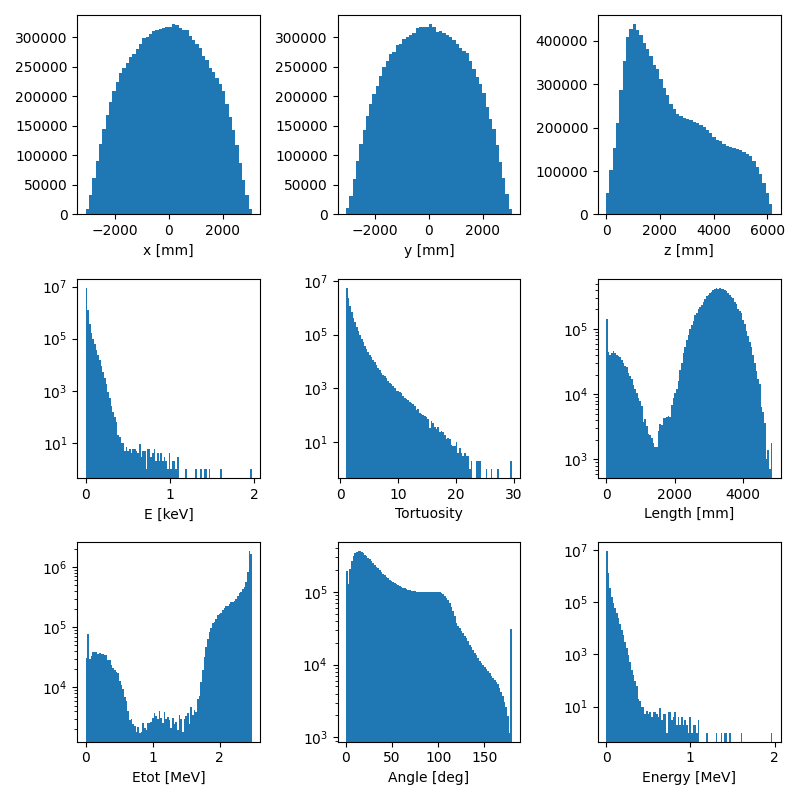

In [7]:
# Make some plots of the feature vectors before normalizing
fig  = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(331)
ax.hist(df_merged.x, bins = 50);
ax.set_xlabel("x [mm]")

ax = fig.add_subplot(332)
ax.hist(df_merged.y, bins = 50);
ax.set_xlabel("y [mm]")

ax = fig.add_subplot(333)
ax.hist(df_merged.z, bins = 50);
ax.set_xlabel("z [mm]")

ax = fig.add_subplot(334)
ax.hist(df_merged.energy, bins=100);
ax.set_xlabel("E [keV]")
ax.semilogy()

ax = fig.add_subplot(335)
ax.hist(df_merged.Tortuosity, bins=100);
ax.set_xlabel("Tortuosity")
ax.semilogy()

ax = fig.add_subplot(336)
ax.hist(df_merged.length, bins=100);
ax.set_xlabel("Length [mm]")
ax.semilogy()

ax = fig.add_subplot(337)
ax.hist(df_merged.Etot, bins=100);
ax.set_xlabel("Etot [MeV]")
ax.semilogy()

ax = fig.add_subplot(338)
ax.hist(df_merged.angle, bins=100);
ax.set_xlabel("Angle [deg]")
ax.semilogy()

ax = fig.add_subplot(339)
ax.hist(df_merged.energy, bins=100);
ax.set_xlabel("Energy [MeV]")
ax.semilogy()

plt.tight_layout()


In [8]:
def MinMaxScale(df, label):
    # Min-Max scaling
    var_min = df[label].min()
    var_max = df[label].max()
    df[label] = (df[label] - var_min) / (var_max - var_min)
    return df

# Function for Min-Max normalization
def normalize_group(group):
    # Avoid division by zero if a group has only one point or max == min
    if group.max() == group.min():
        return group * 0.0
    return (group - group.min()) / (group.max() - group.min())

# Normalize the columns
xyz_mean = df_merged[["x", "y", "z"]].mean()
xyz_std  = df_merged[["x", "y", "z"]].std()
df_merged[["x", "y", "z"]] = (df_merged[["x", "y", "z"]] - xyz_mean) / xyz_std


# Apply clipping to the energy
df_merged['energy'] = df_merged['energy'].clip(upper=0.4)

df_merged = MinMaxScale(df_merged, "energy")
df_merged = MinMaxScale(df_merged, "Tortuosity")
df_merged = MinMaxScale(df_merged, "length")
df_merged = MinMaxScale(df_merged, "Etot")
df_merged = MinMaxScale(df_merged, "angle")

# Normalize the cumulative distance per event and track id
df_merged['cum_dist_norm'] = df_merged.groupby(['event_id','trkID'])['cumulative_distance'].transform(normalize_group)

display(df_merged)

,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity,Type,subType,length,Etot,label,cum_dist_norm
0,122,-1.098816,-1.057332,-0.649785,0.086234,0,0,1,0,0.000000,0.000000,3.917017e-02,1.089913,0nubb,0nubb,0.880156,0.982135,Primary,0.000000
1,122,-1.090751,-1.057266,-0.646935,0.234576,0,1,1,0,12.174049,0.766934,3.917017e-02,1.089913,0nubb,0nubb,0.880156,0.982135,Primary,0.002846
2,122,-1.087519,-1.050557,-0.646270,0.104714,0,2,1,0,22.711329,0.353276,3.643778e-02,1.173988,0nubb,0nubb,0.880156,0.982135,Primary,0.005310
3,122,-1.082122,-1.053405,-0.649293,0.007603,0,5,1,0,32.481788,0.524949,3.483719e-02,1.322042,0nubb,0nubb,0.880156,0.982135,Primary,0.007595
4,122,-1.082657,-1.058850,-0.646248,0.009030,0,4,1,0,41.499549,0.488239,3.707487e-02,1.533477,0nubb,0nubb,0.880156,0.982135,Primary,0.009703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11116004,70151,-0.865656,-1.744012,0.781156,0.003718,0,124,1,0,3563.305336,0.562714,2.172413e-02,0.885389,Bkg,single,0.740914,0.993380,Primary,0.989739
11116005,70151,-0.875849,-1.751550,0.787610,0.404792,0,117,1,0,3583.732116,0.628216,2.686492e-02,0.952384,Bkg,single,0.740914,0.993380,Primary,0.995413
11116006,70151,-0.885474,-1.749825,0.781680,0.148040,0,109,1,0,3600.248059,0.425522,2.532360e-02,0.867392,Bkg,single,0.740914,0.993380,Primary,1.000000
11116007,70151,-1.129344,-1.430525,0.194962,0.014707,0,61,0,1,30.999426,0.986208,3.864245e-18,0.000000,Bkg,single,0.011649,0.003789,Delta0,0.000000


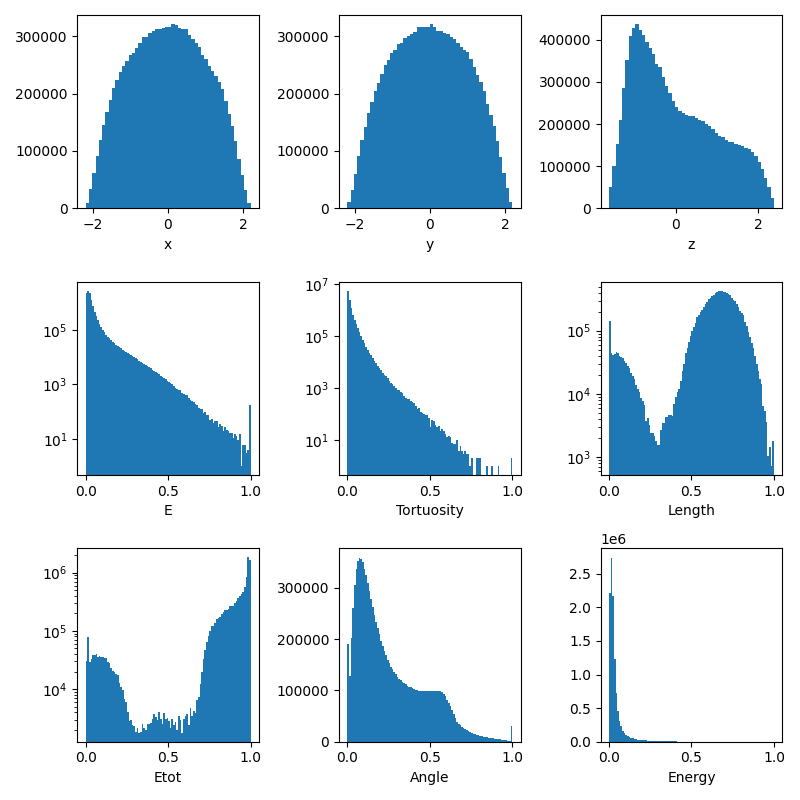

In [9]:
# Make some plots of the feature vectors after normalizing
fig  = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(331)
ax.hist(df_merged.x, bins = 50);
ax.set_xlabel("x")

ax = fig.add_subplot(332)
ax.hist(df_merged.y, bins = 50);
ax.set_xlabel("y")

ax = fig.add_subplot(333)
ax.hist(df_merged.z, bins = 50);
ax.set_xlabel("z")

ax = fig.add_subplot(334)
ax.hist(df_merged.energy, bins=100);
ax.set_xlabel("E")
ax.semilogy()

ax = fig.add_subplot(335)
ax.hist(df_merged.Tortuosity, bins=100);
ax.set_xlabel("Tortuosity")
ax.semilogy()

ax = fig.add_subplot(336)
ax.hist(df_merged.length, bins=100);
ax.set_xlabel("Length")
ax.semilogy()

ax = fig.add_subplot(337)
ax.hist(df_merged.Etot, bins=100);
ax.set_xlabel("Etot")
ax.semilogy()

ax = fig.add_subplot(338)
ax.hist(df_merged.angle, bins=100);
ax.set_xlabel("Angle")
# ax.semilogy()

ax = fig.add_subplot(339)
ax.hist(df_merged.energy, bins=100);
ax.set_xlabel("Energy")
# ax.semilogy()


plt.tight_layout()



[]

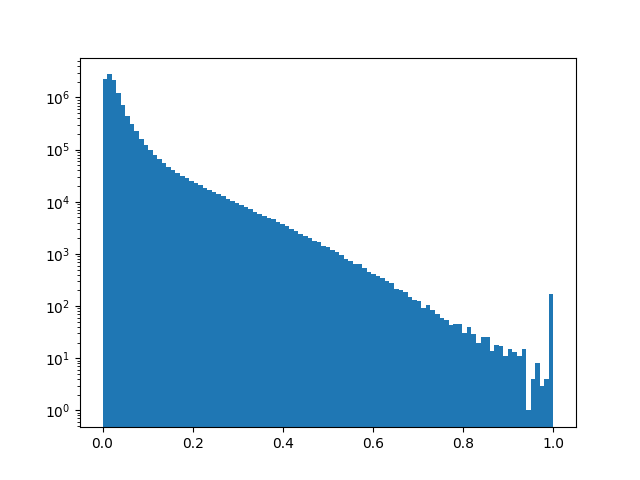

In [10]:
# Plot angle vs energy histogram

plt.figure()

# plt.hist2d(df_merged.energy, df_merged.angle, bins = [100, 100]);
# plt.semilogz()
plt.hist(df_merged.energy, bins = np.linspace(0,1,100));
plt.semilogy()



In [11]:
# Convert the label category to a trainable parameter
df_merged['label_cat'] = (
    df_merged['label']
      .str.replace(r'^Delta\d+$', 'Delta', regex=True)
      .str.replace(r'^BremDelta\d+$', 'BremDelta', regex=True)
)

df_merged['label_cat'] = df_merged['label_cat'].astype('category')
df_merged['label_cat'] = df_merged['label_cat'].cat.set_categories(['Primary', 'Delta', 'Brem', 'BremDelta'],ordered=False )

# Integer encoding for training
df_merged['label_id'] = df_merged['label_cat'].cat.codes

display(df_merged)

,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,...,Tortuosity,Squiglicity,Type,subType,length,Etot,label,cum_dist_norm,label_cat,label_id
0,122,-1.098816,-1.057332,-0.649785,0.086234,0,0,1,0,0.000000,...,3.917017e-02,1.089913,0nubb,0nubb,0.880156,0.982135,Primary,0.000000,Primary,0
1,122,-1.090751,-1.057266,-0.646935,0.234576,0,1,1,0,12.174049,...,3.917017e-02,1.089913,0nubb,0nubb,0.880156,0.982135,Primary,0.002846,Primary,0
2,122,-1.087519,-1.050557,-0.646270,0.104714,0,2,1,0,22.711329,...,3.643778e-02,1.173988,0nubb,0nubb,0.880156,0.982135,Primary,0.005310,Primary,0
3,122,-1.082122,-1.053405,-0.649293,0.007603,0,5,1,0,32.481788,...,3.483719e-02,1.322042,0nubb,0nubb,0.880156,0.982135,Primary,0.007595,Primary,0
4,122,-1.082657,-1.058850,-0.646248,0.009030,0,4,1,0,41.499549,...,3.707487e-02,1.533477,0nubb,0nubb,0.880156,0.982135,Primary,0.009703,Primary,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11116004,70151,-0.865656,-1.744012,0.781156,0.003718,0,124,1,0,3563.305336,...,2.172413e-02,0.885389,Bkg,single,0.740914,0.993380,Primary,0.989739,Primary,0
11116005,70151,-0.875849,-1.751550,0.787610,0.404792,0,117,1,0,3583.732116,...,2.686492e-02,0.952384,Bkg,single,0.740914,0.993380,Primary,0.995413,Primary,0
11116006,70151,-0.885474,-1.749825,0.781680,0.148040,0,109,1,0,3600.248059,...,2.532360e-02,0.867392,Bkg,single,0.740914,0.993380,Primary,1.000000,Primary,0
11116007,70151,-1.129344,-1.430525,0.194962,0.014707,0,61,0,1,30.999426,...,3.864245e-18,0.000000,Bkg,single,0.011649,0.003789,Delta0,0.000000,Delta,1


In [12]:
# Split the dataset based on the event ids not the rows

# Event-level labels (one row per event)
event_labels = (df_merged.groupby("event_id")["Type"].first().eq("0nubb").astype(int))
print(event_labels.value_counts().rename({1: "0nubb", 0: "Bkg"}))

event_ids = event_labels.index.values
event_y   = event_labels.values

ev_tmp, ev_test, y_tmp, y_test   = train_test_split(event_ids, event_y, test_size=0.10, stratify=event_y, random_state=42)
ev_train, ev_val, y_train, y_val = train_test_split(ev_tmp,y_tmp, test_size=2/9, stratify=y_tmp, random_state=42)

train_df = df_merged[df_merged["event_id"].isin(ev_train)].copy()
val_df   = df_merged[df_merged["event_id"].isin(ev_val)].copy()
test_df  = df_merged[df_merged["event_id"].isin(ev_test)].copy()

assert set(train_df.event_id).isdisjoint(val_df.event_id)
assert set(train_df.event_id).isdisjoint(test_df.event_id)

label_map = {"0nubb": 1, "Bkg": 0}
train_df["label"] = (train_df["Type"] == "0nubb").astype(int)
val_df["label"]   = (val_df["Type"] == "0nubb").astype(int)
test_df["label"]  = (test_df["Type"] == "0nubb").astype(int)


Type
0nubb    35050
Bkg      33212
Name: count, dtype: int64


In [13]:
# Data Loaders
# Function to convert the df to a graph

# Desired node features:
# Energy of node
# X,Y,Z of node -- possibly remove these...
# Tortuosity of node
# Energy of track which node belongs to
# Length of track which node belongs to
# Class of track e.g. Primary, Delta, Brem, BremDelta

# Edge features
# Displacement of node
# Angle of node to next node

# Connections
# Use connections provided by the tracking algorithm. 

def event_to_radius_graph(event_df, r=15.0, max_neighbors=32):
    
    pos = torch.tensor(
        event_df[["x", "y", "z"]].values,
        dtype=torch.float32
    ) # N rows of [x,y,z]

    x = torch.tensor(event_df[["x", "y", "z", "energy"]].values, dtype=torch.float32) # (N,4): N rows of [x,y,z,E]

    # Computes graph edges to all points within a given distance.
    # Outputs in Coordinate List (COO) format
    edge_index = radius_graph(pos, r=r, max_num_neighbors=max_neighbors, loop=False) # (2,E), E = number of edges containing pairs of [source_node_index, target_node_index].

    # Source and Destination -- indexes to the pos and x vectors
    src, dst = edge_index

    delta = pos[dst] - pos[src]
    dist = torch.norm(delta, dim=1, keepdim=True) # calc distance between nodes

    edge_attr = torch.cat([delta, dist], dim=1)  # (E, 4) [Δx,Δy,Δz,distance]

    y = torch.tensor([event_df["label"].iloc[0]],dtype=torch.long)

    return Data(
        x=x,
        pos=pos,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y
    )

def event_to_track_graph(event_df, Track):
    
    # Reset the index
    event_df = event_df.reset_index(drop=True)
    
    pos = torch.tensor(
        event_df[["x", "y", "z"]].values,
        dtype=torch.float32
    ) # N rows of [x,y,z]
    
    x = torch.tensor(event_df[["z", "energy", "Tortuosity", "cum_dist_norm", "label_id"]].values, dtype=torch.float32) # (N,5): N rows of these features
    event_id = torch.tensor(event_df.event_id.unique())

    # Build the track
    edge_index, edge_attr = build_track_edges_with_attr(event_df, Track, pos)
    
    y = torch.tensor([event_df["label"].iloc[0]],dtype=torch.long)
    
    return Data(x=x, pos=pos, edge_index=edge_index, edge_attr=edge_attr, y=y, event_id=event_id)

def build_track_edges_with_attr(event_df, tracks, pos):
    src = []
    dst = []
    edge_attr = []
    prev_dir = None  # for angle computation

    for t in tracks:
        nodes = t['nodes']
        for i in range(len(nodes) - 1):
            u = nodes[i]
            v = nodes[i + 1]

            # displacement vector
            d = pos[v] - pos[u]      # (dx, dy, dz)
            d_norm = d / 10.         # Divide by 10 to get a scale closer to ~1
            dist = torch.norm(d)     # |d|

            # direction / angle
            direction = d / (dist + 1e-8)
            
            # angle wrt previous segment
            if prev_dir is None:
                theta_norm = torch.tensor(0.0)
            else:
                cos_theta = torch.dot(prev_dir, direction)
                cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
                theta = torch.acos(cos_theta)
                theta_norm = theta / math.pi # normalize angle
            
            prev_dir = direction

            src.append(u)
            dst.append(v)
            
            # Third column is flag to tell if we added a brem connection or not
            edge_attr.append(torch.tensor([dist, 0.0], dtype=torch.float))
    
    # Map the nodes "id" to index in the dataframe
    id_map = {original_id: i for i, original_id in enumerate(event_df['id'])}
    src_indices = [id_map[id] for id in src]
    dst_indices = [id_map[id] for id in dst]
    
    # Add Brem Connections to the Primary Track
    # Uses sequential index from df, no need to remap these indices
    src_indices, dst_indices, edge_attr = AddBremConnection(event_df, tracks, src_indices, dst_indices, edge_attr)

    # edge_index = torch.tensor([src, dst], dtype=torch.long)
    edge_index = torch.tensor([src_indices, dst_indices], dtype=torch.long)
    edge_attr = torch.stack(edge_attr)

    return edge_index, edge_attr

# Need to add an edge connection between brems and the primary track
def AddBremConnection(event_df, tracks, src_indices, dst_indices, edge_attr):
    
    # Get the primary track
    for t in tracks:
        if (t["label"] == "Primary"):
            df_primary = event_df[event_df.id.isin(t["nodes"])]
            
    for t in tracks:
        
        # Skip making connections with deltas
        if ("Delta" in t["label"] or "Primary" in t["label"] ):
            continue
        
        df_track = event_df[event_df.id.isin(t["nodes"])]
        
        A = df_track[["x", "y", "z"]].to_numpy()
        B = df_primary[["x", "y", "z"]].to_numpy()

        dist = np.linalg.norm(A[:, None, :] - B[None, :, :], axis=2)

        # index of global minimum
        iA, iB = np.unravel_index(dist.argmin(), dist.shape)

        # actual DataFrame indices
        idx_A = df_track.index[iA]
        idx_B = df_primary.index[iB]
        min_distance = dist[iA, iB]
        
        # Add bi-direction to these connections and angle of zero
        src_indices.append(idx_A)
        dst_indices.append(idx_B)
        
        # Third column is flag to tell if we added a brem connection or not. Set to 1 here
        edge_attr.append(torch.tensor([min_distance, 1.0], dtype=torch.float))

        src_indices.append(idx_A)
        dst_indices.append(idx_B)
        edge_attr.append(torch.tensor([min_distance, 1.0], dtype=torch.float))
        
    
    return src_indices, dst_indices, edge_attr



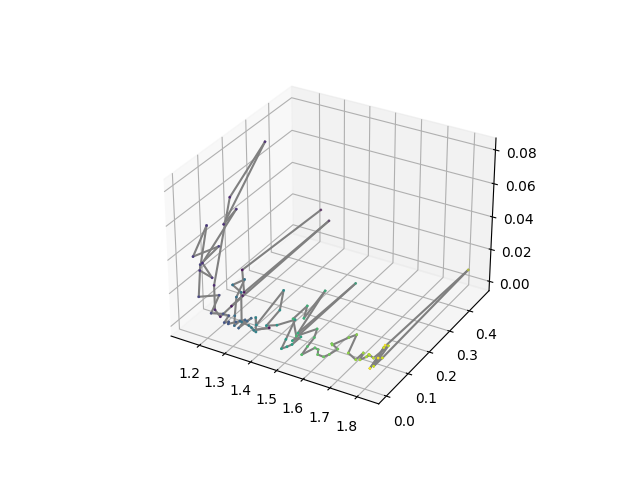

In [14]:
# Make a plot of the graph data 
event_id = 3
event_list = train_df.event_id.unique()
event_connection_count = connection_counts[ event_list[event_id]]
Track = Tracks[event_list[event_id]]
event = train_df[train_df.event_id == event_list[event_id]]
event.index = event.id
# display(event)

# for t in Track:
#     print(t)

INDX_X=0
INDX_Y=1
INDX_Z=2
INDX_E=3
event_graph = event_to_track_graph(event,Track)
# print(event_graph.x[:, INDX_Y])
src = event_graph.edge_index[0,:]
dst = event_graph.edge_index[1,:]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(event_graph.x[:, INDX_X], event_graph.x[:, INDX_Y], event_graph.x[:, INDX_Z], c = event_graph.x[:, INDX_E], s=1)

for i in range(len(src)):
    x_pos = [event_graph.x[src[i], INDX_X].numpy(),  event_graph.x[dst[i], INDX_X].numpy()]
    y_pos = [event_graph.x[src[i], INDX_Y].numpy(),  event_graph.x[dst[i], INDX_Y].numpy()]
    z_pos = [event_graph.x[src[i], INDX_Z].numpy(),  event_graph.x[dst[i], INDX_Z].numpy()]
    ax.plot( x_pos, y_pos, z_pos, linestyle = "-" , c="grey")


In [15]:
def build_graph_dataset(df):
    graphs = []
    for ev_id in df.event_id.unique():
        # graphs.append(event_to_radius_graph(ev_df, r=0.3)) # Radius connections
        graphs.append(event_to_track_graph(df[df.event_id == ev_id], Tracks[ev_id])) # Track connections
    return graphs

train_graphs = build_graph_dataset(train_df)
val_graphs   = build_graph_dataset(val_df)
test_graphs  = build_graph_dataset(test_df)

train_loader = DataLoader(train_graphs,batch_size=8, shuffle=True,  num_workers=10, pin_memory=True)
val_loader   = DataLoader(val_graphs,  batch_size=16,shuffle=False, num_workers=10, pin_memory=True)
test_loader  = DataLoader(test_graphs, batch_size=16,shuffle=False, num_workers=10, pin_memory=True)

In [16]:
# Define the GNN
class GATNet(nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, heads=4):
        super().__init__()

        self.conv1 = GATConv(num_node_features, hidden_channels, heads=heads, concat=False) # concat False keeps hidden_channels fixed
        self.conv2 = GATConv(hidden_channels,   hidden_channels, heads=heads, concat=False)
        self.conv3 = GATConv(hidden_channels,   hidden_channels, heads=1,     concat=False)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x
    
class GATNetEdge(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, edge_dim, heads=4):
        super().__init__()

        self.conv1 = GATConv( num_node_features, hidden_channels, heads=heads, concat=False, edge_dim=edge_dim)
        self.conv2 = GATConv( hidden_channels,   hidden_channels, heads=heads, concat=False, edge_dim=edge_dim)
        self.conv3 = GATConv( hidden_channels,   hidden_channels, heads=1,     concat=False, edge_dim=edge_dim)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = getattr(data, 'edge_attr', None)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)

        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x
    
class EventTransformerConv(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes, num_node_features, edge_dim):
        super().__init__()
        self.conv1 = TransformerConv(num_node_features, hidden_channels, edge_dim=edge_dim)
        self.conv2 = TransformerConv(hidden_channels, hidden_channels, edge_dim=edge_dim)
        self.conv3 = TransformerConv(hidden_channels, hidden_channels, edge_dim=edge_dim)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = getattr(data, 'edge_attr', None)
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)

        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

In [17]:
def accuracy_from_logits(logits, y_true):
    preds = logits.argmax(dim=1)
    return (preds == y_true).float().mean().item()


# Define your ML models here
# model = GATNetEdge(hidden_channels=64, num_classes=2, edge_dim=2, num_node_features = 5).to(device) # GAT + Edge Features
model = EventTransformerConv(hidden_channels=64, num_classes=2, num_node_features=5, edge_dim=2).to(device) # Transformer model


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss(
    weight=torch.tensor([1.0, 1.0])  # [background, signal]
).to(device)

train_loss_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in range(20):

    # -------- training --------
    # Put the model in training mode, gradients will be computed
    model.train() 
    train_loss = 0.0 # Sum the loss over all batches, then average it

    # Loop over training batches
    for data in train_loader:
        
        data = data.to(device) # Move the whole graph batch to GPU
        
        # print("x:", data.x.shape)
        # print("edge_index:", data.edge_index.shape)
        # print("edge_attr:", data.edge_attr.shape)
        
        optimizer.zero_grad()            # Clear old features
        logits = model(data)             # Data flows through the network, the output is called logits (raw scores not probabilities) -- forward pass
        loss = criterion(logits, data.y) # Compares the predictions (logits) with the true labels (yb)
        loss.backward()                  # Computes the gradients of the loss (stored in param.grad for every model param)
        optimizer.step()                 # Uses the gradients to update the weights. Depends on the optimizer e.g. SGD, Adam etc -- this is the learning step

        train_loss += loss.item() * data.num_graphs # Accumulates the total loss. loss.item() returns the loss for this batch. So multiply by batch size data.num_graphs 

    train_loss /= len(train_loader.dataset) # Average the training loss over the total dataset
    train_loss_hist.append(train_loss)

    # -------- validation --------
    model.eval() # Disables dropout, freezes batchnorm statistics, ensures deterministic behaviour
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad(): # Disables gradient tracking (saves memory, speeds up evalulation, prevents accidental backpropagation)
        for data in val_loader:
            data = data.to(device) # Move the whole graph batch to GPU
            
            logits = model(data)
            loss = criterion(logits, data.y)

            val_loss += loss.item() * data.num_graphs
            val_acc += accuracy_from_logits(logits, data.y) * data.num_graphs # Converts logits -> predicted class, compares with y

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    print(
        f"Epoch {epoch+1:03d} | "
        f"Train loss: {train_loss:.4f} | "
        f"Val loss: {val_loss:.4f} | "
        f"Val acc: {val_acc:.3f}"
    )

model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for data in test_loader:
        
        data = data.to(device) # Move the whole graph batch to GPU
        
        logits = model(data)
        loss = criterion(logits, data.y)

        test_loss += loss.item() * data.num_graphs
        test_acc  += accuracy_from_logits(logits, data.y) * data.num_graphs

test_loss /= len(test_loader.dataset)
test_acc  /= len(test_loader.dataset)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.3f}")

Epoch 001 | Train loss: 0.5720 | Val loss: 0.5558 | Val acc: 0.727
Epoch 002 | Train loss: 0.5380 | Val loss: 0.5138 | Val acc: 0.757
Epoch 003 | Train loss: 0.4726 | Val loss: 0.4483 | Val acc: 0.791
Epoch 004 | Train loss: 0.4486 | Val loss: 0.4389 | Val acc: 0.798
Epoch 005 | Train loss: 0.4355 | Val loss: 0.4678 | Val acc: 0.796
Epoch 006 | Train loss: 0.4298 | Val loss: 0.4256 | Val acc: 0.811
Epoch 007 | Train loss: 0.4240 | Val loss: 0.4404 | Val acc: 0.806
Epoch 008 | Train loss: 0.4184 | Val loss: 0.4248 | Val acc: 0.801
Epoch 009 | Train loss: 0.4139 | Val loss: 0.4498 | Val acc: 0.790
Epoch 010 | Train loss: 0.4117 | Val loss: 0.4196 | Val acc: 0.811
Epoch 011 | Train loss: 0.4084 | Val loss: 0.4128 | Val acc: 0.813
Epoch 012 | Train loss: 0.4066 | Val loss: 0.4184 | Val acc: 0.813
Epoch 013 | Train loss: 0.4046 | Val loss: 0.4279 | Val acc: 0.810
Epoch 014 | Train loss: 0.4041 | Val loss: 0.4116 | Val acc: 0.815
Epoch 015 | Train loss: 0.4005 | Val loss: 0.4100 | Val acc: 0

In [18]:
def compute_roc(model, loader, device):
    model.eval()
    y_true, y_score, p_signal_bkg, p_signal_sig, event_ids = [], [], [], [], []

    with torch.no_grad():
        # Loops over in batches specified in dataloader, returns array of length of the batch size. 
        for data in loader:
            data = data.to(device)
            logits = model(data)
            probs = torch.softmax(logits, dim=1) # List of length batch size, 2 rows, [p_bkg, p_sig]
            
            p_signal = probs[:, 1].cpu() # Get the signal column probs
            y        = data.y.cpu()      # Get the y labels
            
            y_score.append(p_signal)
            y_true.append(y)
            event_ids.append(data.event_id.cpu())
            
            # Append scores depending on true classification
            p_signal_bkg.append(p_signal[y.numpy() == 0])
            p_signal_sig.append(p_signal[y.numpy() == 1])

    y_true  = torch.cat(y_true).numpy()
    y_score = torch.cat(y_score).numpy()
    event_ids = torch.cat(event_ids).numpy()
    
    p_signal_bkg = np.concatenate(p_signal_bkg)
    p_signal_sig = np.concatenate(p_signal_sig)
    
    df_scores = pd.DataFrame({"event_id":event_ids, "y_score":y_score, "y_true":y_true})

    fpr, tpr, _ = roc_curve(y_true, y_score)
    
    return fpr, tpr, auc(fpr, tpr), df_scores

fpr_tr,   tpr_tr, auc_tr,   df_scores_tr  = compute_roc(model, train_loader, device)
fpr_va,   tpr_va, auc_va,   df_scores_va = compute_roc(model, val_loader,   device)
fpr_tst, tpr_tst, auc_tst,  df_scores_tst = compute_roc(model, test_loader,  device)
df_scores_all = pd.concat([df_scores_tr, df_scores_va, df_scores_tst])
display(df_scores_all)

,event_id,y_score,y_true
0,163618,0.770157,1
1,143252,0.885277,1
2,154709,0.854924,1
3,566490128,0.662402,0
4,154338,0.390950,1
...,...,...,...
6822,6932190,0.045892,0
6823,6946249,0.771852,0
6824,6946500,0.261095,0
6825,6953238,0.001141,0


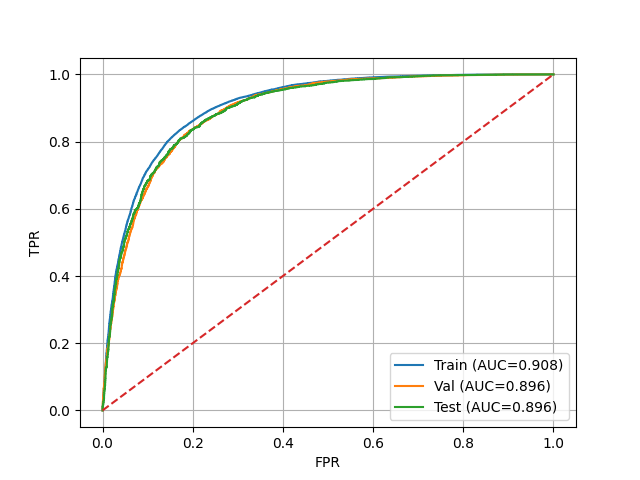

Val AUC: 0.896 


In [19]:
plt.figure()
plt.plot(fpr_tr, tpr_tr, label=f"Train (AUC={auc_tr:.3f})")
plt.plot(fpr_va, tpr_va, label=f"Val (AUC={auc_va:.3f})")
plt.plot(fpr_tst, tpr_tst, label=f"Test (AUC={auc_va:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(True)
plt.show()
print(f"Val AUC: {auc_va:.3f} ")


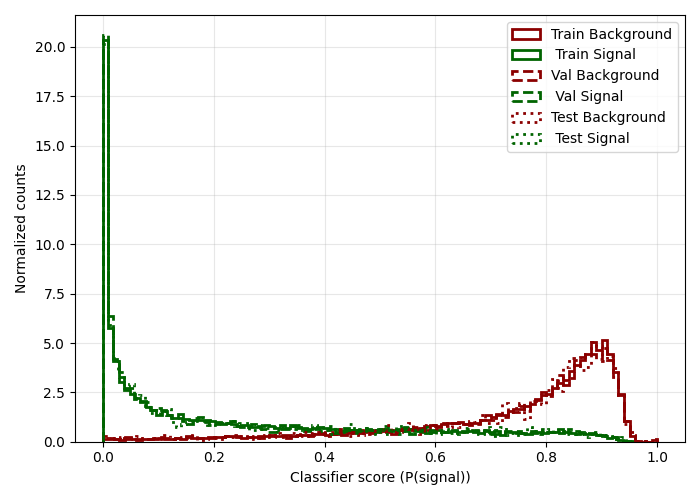

0.1526255570275804 0.19888730385164055


In [20]:
plt.figure(figsize=(7,5))

bins = 100


plt.hist(df_scores_tr[df_scores_tr.y_true == 1].y_score,bins=bins,density=True,histtype='step',linewidth=2,label='Train Background', linestyle = "-", color = "darkred")
plt.hist(df_scores_tr[df_scores_tr.y_true == 0].y_score,bins=bins,density=True,histtype='step',linewidth=2,label=' Train Signal', linestyle = "-", color = "darkgreen")

plt.hist(df_scores_va[df_scores_va.y_true == 1].y_score,bins=bins,density=True,histtype='step',linewidth=2,label='Val Background', linestyle = "--", color = "darkred")
plt.hist(df_scores_va[df_scores_va.y_true == 0].y_score,bins=bins,density=True,histtype='step',linewidth=2,label=' Val Signal', linestyle = "--", color = "darkgreen")

plt.hist(df_scores_tst[df_scores_tst.y_true == 1].y_score,bins=bins,density=True,histtype='step',linewidth=2,label='Test Background', linestyle = ":", color = "darkred")
plt.hist(df_scores_tst[df_scores_tst.y_true == 0].y_score,bins=bins,density=True,histtype='step',linewidth=2,label=' Test Signal', linestyle = ":", color = "darkgreen")


plt.xlabel("Classifier score (P(signal))")
plt.ylabel("Normalized counts")
plt.legend()
plt.grid(alpha=0.3)

# plt.semilogy()
plt.tight_layout()
plt.show()

cut = 0.6
signal_eff = len(df_scores_all[ (df_scores_all.y_true == 0) & (df_scores_all.y_score > cut)])/len(df_scores_all[ (df_scores_all.y_true == 0)])
bkg_rej = 1 - len(df_scores_all[ (df_scores_all.y_true == 1) & (df_scores_all.y_score > cut)])/len(df_scores_all[ (df_scores_all.y_true == 1)])
print(signal_eff, bkg_rej)

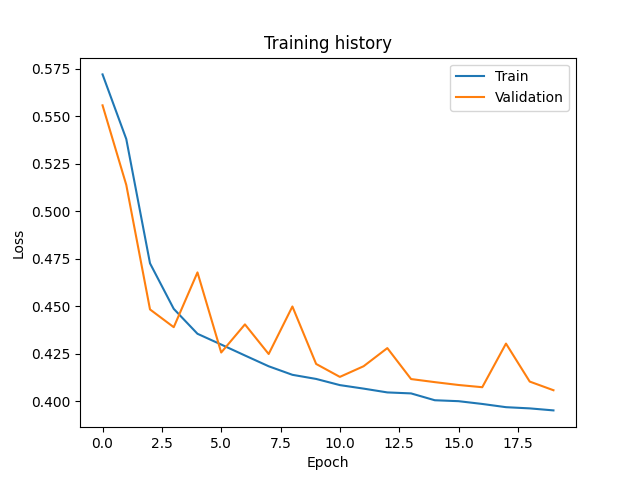

In [21]:
plt.figure()
plt.plot(train_loss_hist, label='Train')
plt.plot(val_loss_hist, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training history')
plt.show()



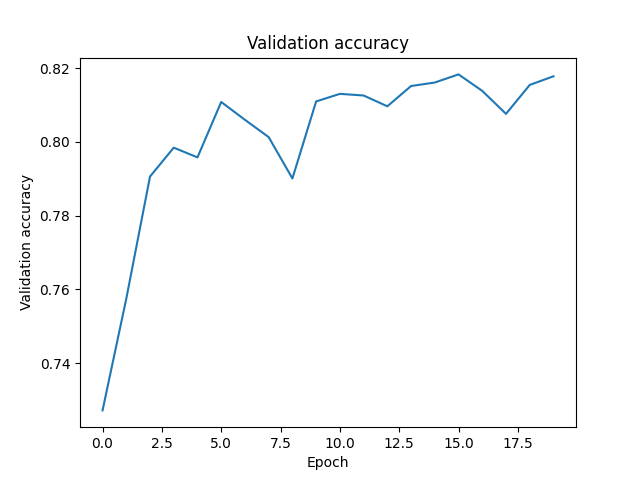

In [22]:
plt.figure()
plt.plot(val_acc_hist)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy')
plt.show()

In [23]:
# Merge categories column to df score so we can plot the performance vs background type
# display(df_merged[["event_id", "subType"]])
df_scores_merged = df_merged.drop_duplicates(subset=['event_id'])
df_scores_merged = df_scores_merged[["event_id", "subType"]]

df_scores_merged = pd.merge(df_scores_merged, df_scores_all, on="event_id")
display(df_scores_merged)


,event_id,subType,y_score,y_true
0,122,0nubb,0.557873,1
1,123,0nubb,0.007209,1
2,124,0nubb,0.751629,1
3,126,0nubb,0.790312,1
4,127,0nubb,0.717886,1
...,...,...,...,...
68257,69853,single,0.058595,0
68258,70027,single,0.244075,0
68259,70046,single,0.111254,0
68260,70096,single,0.012125,0


Cut =  0.74
Signal Eff:   0.65
Bkg Eff, Bkg Rej, Bkg Rej Fact
Tl ERej:      0.04 0.96 22.52
Bi ERej:      0.08 0.92 11.82
single ERej:  0.11 0.89 9.50


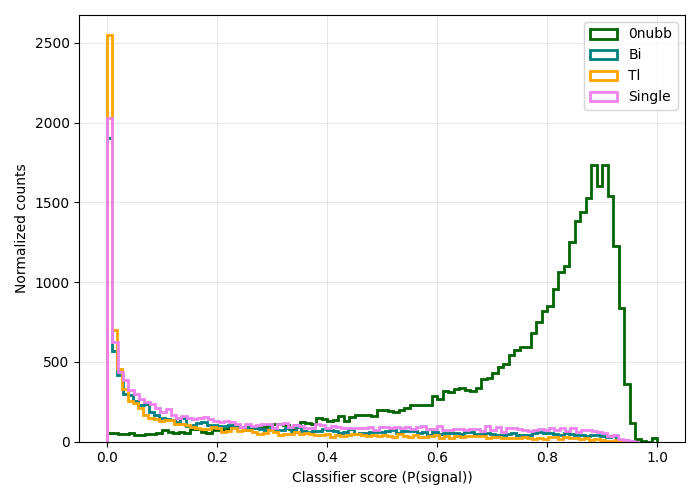

In [27]:
def CalcEfficiency(df, label, cut):
    num = len(df[ (df.subType == label) & (df.y_score > cut)])
    den = len(df[ (df.subType == label)])
    return num/den

cut = 0.74

print("Cut = ", cut)
print(f"Signal Eff:   {CalcEfficiency(df_scores_merged, '0nubb', cut):.2f}")

print("Bkg Eff, Bkg Rej, Bkg Rej Fact")
tl_eff = CalcEfficiency(df_scores_merged, "Tl", cut)
print(f"Tl ERej:      {tl_eff:.2f} {1-tl_eff:.2f} {1/tl_eff:.2f}")

bi_eff = CalcEfficiency(df_scores_merged, "Bi", cut)
print(f"Bi ERej:      {bi_eff:.2f} {1-bi_eff:.2f} {1/bi_eff:.2f}")

s_eff = CalcEfficiency(df_scores_merged, "single", cut)
print(f"single ERej:  {s_eff:.2f} {1-s_eff:.2f} {1/s_eff:.2f}")

plt.figure(figsize=(7,5))

bins = 100

plt.hist(df_scores_merged[ (df_scores_merged.subType == "0nubb")].y_score,bins=bins,density=False,histtype='step',linewidth=2,label='0nubb', color = "darkgreen");
plt.hist(df_scores_merged[ (df_scores_merged.subType == "Bi")].y_score,bins=bins,density=False,histtype='step',linewidth=2,label='Bi', color = "Teal");
plt.hist(df_scores_merged[ (df_scores_merged.subType == "Tl")].y_score,bins=bins,density=False,histtype='step',linewidth=2,label='Tl', color = "Orange");
plt.hist(df_scores_merged[ (df_scores_merged.subType == "single")].y_score,bins=bins,density=False,histtype='step',linewidth=2,label='Single', color = "violet");


plt.xlabel("Classifier score (P(signal))")
plt.ylabel("Normalized counts")
plt.legend()
plt.grid(alpha=0.3)

# plt.semilogy()
plt.tight_layout()
plt.show()



In [25]:
df_out = df_scores_merged.copy()
df_out['subType'] = df_out['subType'].replace({'0nubb': 'ATPC_0nubb', 'Bi': 'ATPC_Bi_ion', 'Tl': 'ATPC_Tl_ion', 'single': 'ATPC_single'})
df_out = df_out[["event_id", "subType", "y_score"]]
df_out = df_out[df_out.y_score > cut]
display(df_out)


df_out[["event_id", "subType"]].to_csv("../eventlists/ATPC_1bar_5percent_GNN.csv", index=False)

print(len(df_out[df_out.subType == "ATPC_0nubb"]))
print(len(df_out[df_out.subType == "ATPC_Bi_ion"]))
print(len(df_out[df_out.subType == "ATPC_Tl_ion"]))
print(len(df_out[df_out.subType == "ATPC_single"]))


,event_id,subType,y_score
2,124,ATPC_0nubb,0.751629
3,126,ATPC_0nubb,0.790312
4,127,ATPC_0nubb,0.717886
5,128,ATPC_0nubb,0.756603
6,129,ATPC_0nubb,0.904108
...,...,...,...
68237,6946248,ATPC_single,0.728394
68238,6946249,ATPC_single,0.771852
68246,6967363,ATPC_single,0.726960
68251,6974339,ATPC_single,0.844727


24530
1067
507
1694
